## Imagery layers and Raster analysis

In [1]:
import arcgis


### Access Landsat imagery

In [2]:
from arcgis.gis import GIS

In [3]:
gis = GIS(profile='agol_profile')

In [4]:
landsat_item = gis.content.search('title: Multispectral Landsat',
                                  'Imagery Layer', outside_org=True) [0]

In [5]:
landsat_item.layers

[<ImageryLayer url:"https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer">]

### View Landsat imagery layer item description

In [6]:
from IPython.display import HTML
HTML(landsat_item.description)

### Access the layers available with the Landsat Imagery Layer item

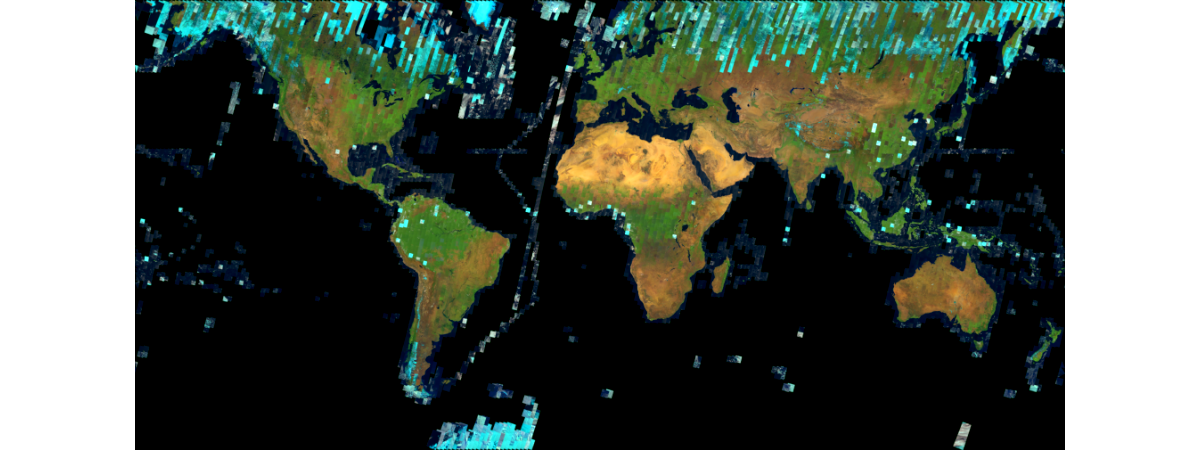

In [8]:
landsat = landsat_item.layers[0]
landsat 

## Explore different wavelength bands

In [9]:
import pandas as pd

In [10]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

BandName  WavelengthMax  WavelengthMin
0       CoastalAerosol          450.0          430.0
1                 Blue          510.0          450.0
2                Green          590.0          530.0
3                  Red          670.0          640.0
4         NearInfrared          880.0          850.0
5  ShortWaveInfrared_1         1650.0         1570.0
6  ShortWaveInfrared_2         2290.0         2110.0
7               Cirrus         1380.0         1360.0
8                  NaN            NaN            NaN

## Visualize the layer in the map widget

In [17]:
m = gis.map('New York, NY')
m

MapView(layout=Layout(height='400px', width='100%'))

In [18]:
m.add_layer(landsat)

In [19]:
import time
from arcgis.raster.functions import apply

for idx, rasterfunc in enumerate(landsat.properties.rasterFunctionInfos):
    print (rasterfunc.name)
    m.add_layer(apply(landsat, rasterfunc.name))
    time.sleep(2)
    if idx > 4:
        break

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA


### Interactive raster processing in Jupyter Notebook

In [14]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

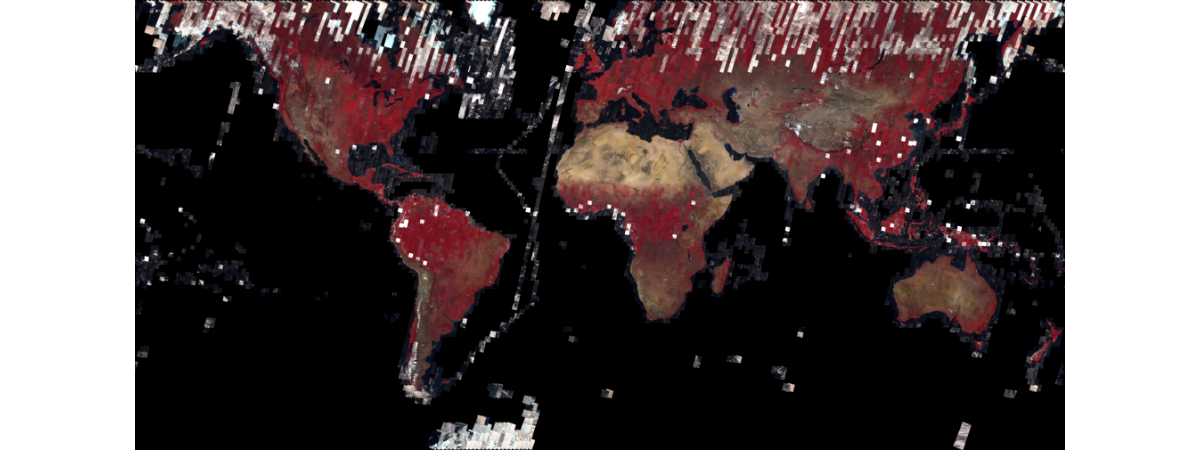

In [15]:
color_infrared 

In [16]:
m = gis.map('Redlands, CA')
m.add_layer(color_infrared)
m

MapView(layout=Layout(height='400px', width='100%'))

### Setting an area of interest

In [22]:
from arcgis.geocoding import geocode
area = geocode('Washington, DC', out_sr=landsat.properties.spatialReference)[0]

In [23]:
color_infrared.extent = area['extent']

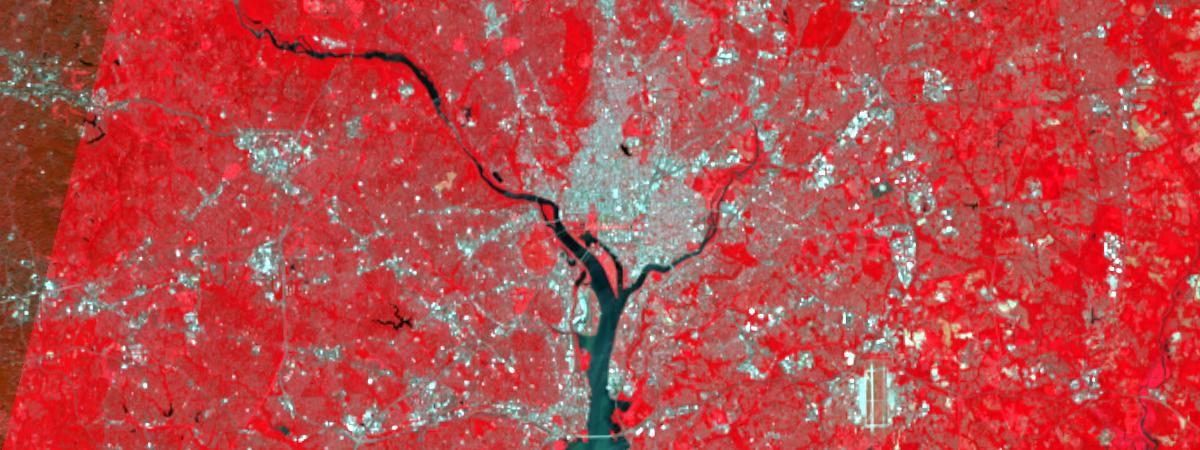

In [24]:
color_infrared

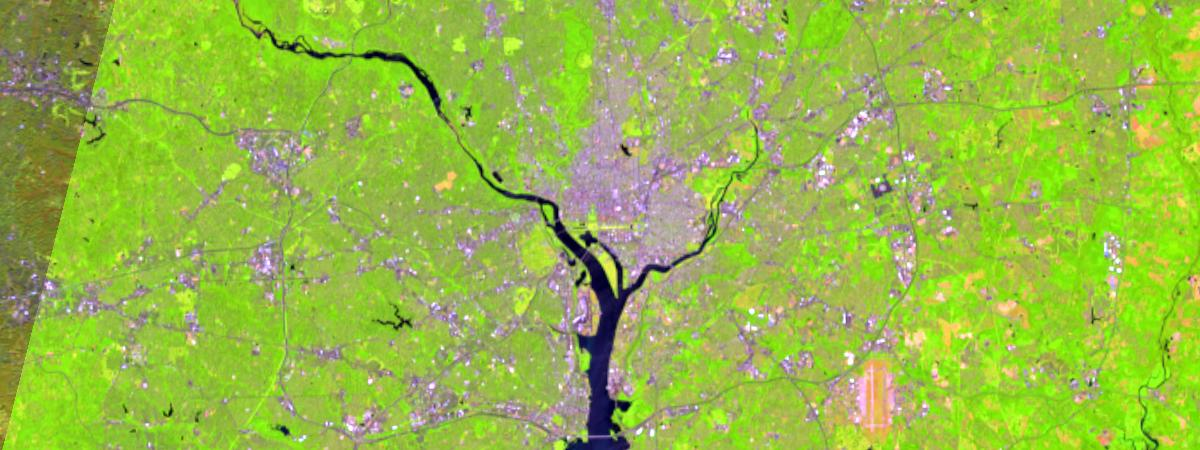

In [25]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [26]:
from IPython.display import Image

Exports an image to binary

In [29]:
img = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

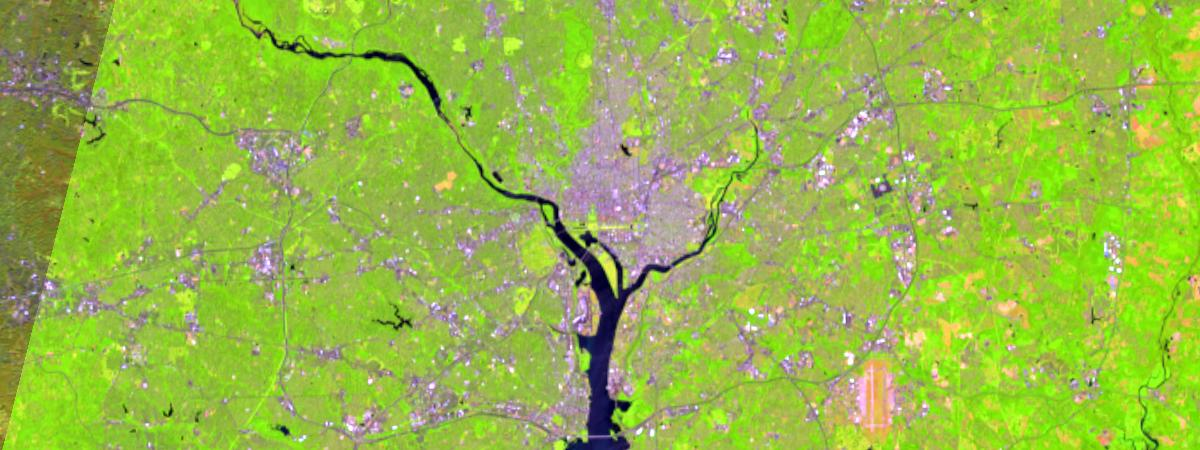

In [30]:
Image(img)

In [31]:
savedimg = landsat.export_image(bbox=area['extent'], size=[1200,450], 
                                f='image', save_folder='.', 
                                save_file='img.jpg')

In [32]:
savedimg

'.\\img.jpg'

In [33]:
from IPython.display import Image

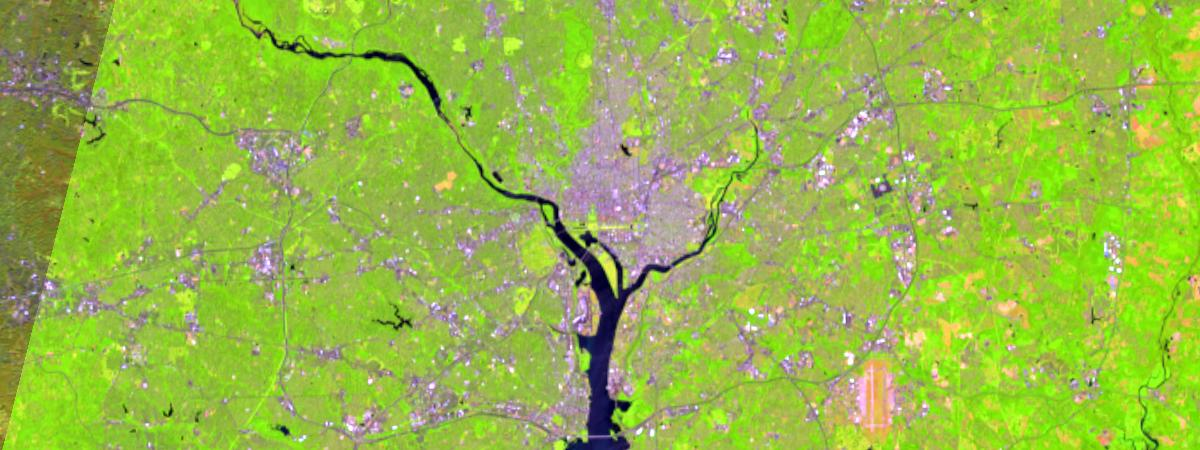

In [34]:
Image(filename=savedimg, width=1200, height=450)

### Exporting images with raster function applied to them

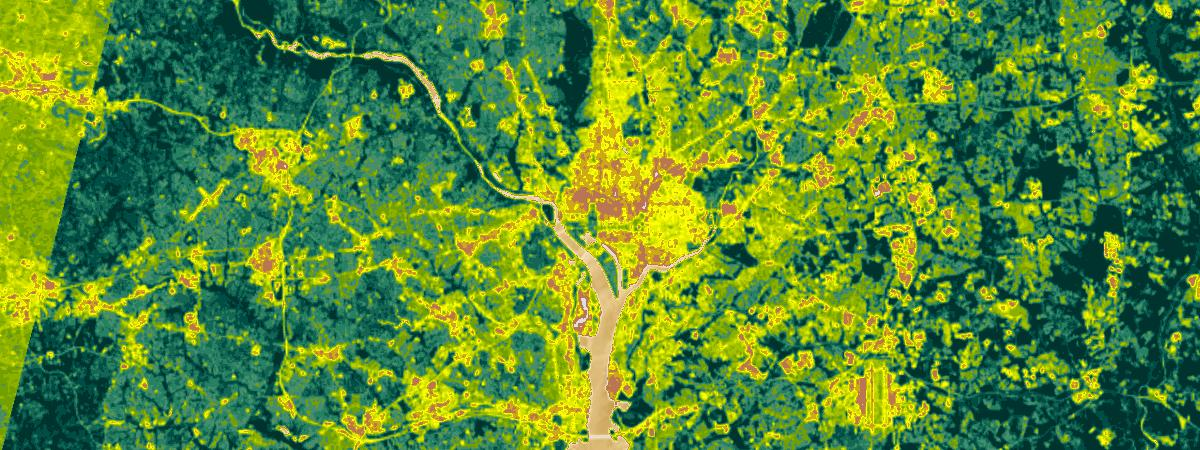

In [35]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized

## Extracting custom bands

In [36]:
from arcgis.raster.functions import stretch, extract_band

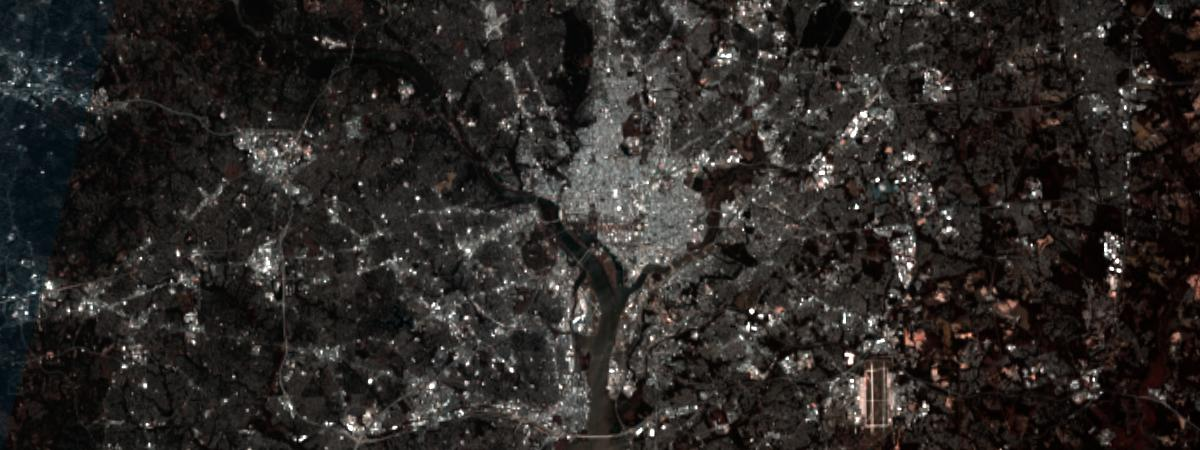

In [44]:
naturalcolor = stretch(extract_band(landsat, [3,2,1]), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, 
                       gamma=[1, 1, 1], dra=True)
naturalcolor

# Clipping to an area of interest

In [45]:
from arcgis.geometry import Geometry, buffer 

In [46]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100, distances=6000, unit='esriMeters')[0]

In [47]:
from  arcgis.geoenrichment import Country
usa = Country.get('US')
redlands = usa.subgeographies.states['California'].zip5['92373']

In [48]:
from arcgis.raster.functions import clip

In [49]:
redclip = clip(landsat, redlands.geometry)

In [50]:
m = gis.map('Redlands, CA')

In [51]:
m 

MapView(layout=Layout(height='400px', width='100%'))

In [52]:
m.add_layer(redclip)

## Select images by where clause, geometry and time range

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
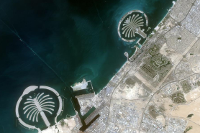

In [66]:
sentinel_item = gis.content.search('Sentinel-2 Views', outside_org=True)[0]
sentinel_item

In [77]:
sentinel = sentinel_item.layers[0]
sentinel.extent = area['extent']
sentinel.url

'https://sentinel.arcgis.com/arcgis/rest/services/Sentinel2/ImageServer'

In [78]:
selected = sentinel.filter_by(where="cloudcover <= .01 and category = 1",
                              geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, Tile_ID, CloudCover", order_by_fields="AcquisitionDate").df
df['acquisitiondate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df.tail(40)

acquisitiondate  cloudcover  objectid    shape_Area   shape_Length  \
4  2018-01-26 00:00:01      0.0000   1472371  1.996244e+10  565162.069130   
5  2018-01-26 00:00:01      0.0000   1472370  1.946603e+10  558090.434133   
6  2018-02-05 00:00:00      0.0060   1539636  1.996244e+10  565162.069130   
7  2018-02-05 00:00:01      0.0000   1538184  1.946603e+10  558090.434133   
8  2018-02-08 16:04:15      0.0000   1561225  2.708161e+09  317005.160198   
9  2018-03-05 16:08:54      0.0000   1774262  8.020895e+09  402448.260115   
10 2018-03-05 16:08:54      0.0000   1774261  2.613751e+09  311658.793815   
11 2018-03-10 16:03:42      0.0051   1816320  8.325762e+09  406644.213411   
12 2018-04-14 16:06:28      0.0052   2117411  2.632980e+09  312568.133591   
13 2018-04-14 16:06:28      0.0000   2117412  8.050290e+09  402769.333774   
14 2018-05-01 15:53:20      0.0000   2258700  1.946603e+10  558090.434133   
15 2018-05-01 15:53:20      0.0000   2258701  1.996244e+10  565162.069130   
16 2018-05-09 16:05:32      0.0009   2324727  8.156766e+09  404300.910647   
17 2018-05-09 16:05:32      0.0000   2324726  2.741357e+09  318853.122276   
18 2018-05-24 16:11:05      0.0000   2440616  2.678306e+09  315248.715678   
19 2018-05-26 15:52:58      0.0099   2647606  1.946603e+10  558090.434133   
20 2018-06-15 15:58:59      0.0000   2921897  1.996244e+10  565162.069130   
21 2018-07-08 16:01:45      0.0000   2902715  2.709063e+09  317158.995210   
22 2018-07-08 16:01:45      0.0000   2923755  8.127027e+09  403900.367151   
23 2018-07-10 16:00:36      0.0000   3379890  1.996244e+10  565162.069130   
24 2018-07-10 16:00:36      0.0001   3147594  1.946603e+10  558090.434133   
25 2018-07-18 16:07:30      0.0056   3010656  2.717146e+09  317639.536979   
26 2018-07-18 16:07:30      0.0034   3010657  8.134632e+09  403983.582241   
27 2018-08-07 16:02:10      0.0014   3200496  2.789075e+09  321680.532395   
28 2018-08-29 16:00:18      0.0015   4330210  1.996244e+10  565162.069130   
29 2018-08-29 16:00:18      0.0001   4330209  1.946603e+10  558090.434133   
30 2018-09-06 16:04:55      0.0000   3542237  2.811839e+09  323012.380694   
31 2018-09-06 16:04:55      0.0004   3542238  8.230755e+09  405313.396154   
32 2018-09-26 16:12:08      0.0001   4087210  2.777995e+09  321078.919454   
33 2018-10-01 16:09:21      0.0000   4146723  2.611639e+09  311182.166270   
34 2018-10-01 16:09:21      0.0000   4330967  8.018824e+09  402462.567375   
35 2018-10-18 15:57:52      0.0000   4389488  1.946603e+10  558090.434133   
36 2018-10-18 15:57:52      0.0031   4389489  1.996244e+10  565162.069130   
37 2018-10-23 15:53:40      0.0000   4681675  1.946603e+10  558090.434133   
38 2018-10-23 15:53:40      0.0000   4681676  1.996244e+10  565162.069130   
39 2018-11-10 16:12:27      0.0000   4580063  2.699032e+09  317726.127457   
40 2018-11-25 16:12:28      0.0000   4713078  2.577551e+09  309492.187896   
41 2018-12-07 16:02:30      0.0001   4997935  1.946603e+10  558090.434133   
42 2018-12-27 16:02:17      0.0001   5171927  1.996244e+10  565162.069130   
43 2019-01-11 16:02:37      0.0021   5177464  1.946603e+10  558090.434133   

                    tile_id                                              SHAPE  
4   20180126T175022_18SUJ_0  {'rings': [[[-8464827.8187, 4687112.761399999]...  
5   20180126T175022_18SUH_0  {'rings': [[[-8463406.3319, 4559255.152099997]...  
6   20180205T192445_18SUJ_0  {'rings': [[[-8464827.8187, 4687112.761399999]...  
7   20180205T192445_18SUH_0  {'rings': [[[-8463406.3319, 4559255.152099997]...  
8   20180208T180129_18SUH_0  {'rings': [[[-8590830.5395, 4601751.7984], [-8...  
9   20180305T194127_18SUJ_0  {'rings': [[[-8569182.9117, 4685386.049999997]...  
10  20180305T194127_18SUH_0  {'rings': [[[-8583723.1204, 4630954.7739999965...  
11  20180310T194202_18SUJ_0  {'rings': [[[-8567030.4221, 4685432.519000001]...  
12  20180414T194139_18SUH_0  {'rings': [[[-8565778.1295, 4697441.680399999]...  
13  20180414T194139_18SUJ_0  {'rings': 

Looking at the shape of the dataframe we see that 46 scenes match the specified criteria:

In [79]:
df.shape

(44, 7)

The footprints of the rasters matching the criteria can be drawn using the map widget:

In [80]:
df['Time'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df['Time'].tail(10)

34   2018-10-01 16:09:21
35   2018-10-18 15:57:52
36   2018-10-18 15:57:52
37   2018-10-23 15:53:40
38   2018-10-23 15:53:40
39   2018-11-10 16:12:27
40   2018-11-25 16:12:28
41   2018-12-07 16:02:30
42   2018-12-27 16:02:17
43   2019-01-11 16:02:37
Name: Time, dtype: datetime64[ns]

### Resolving overlapping pixels in selected rasters

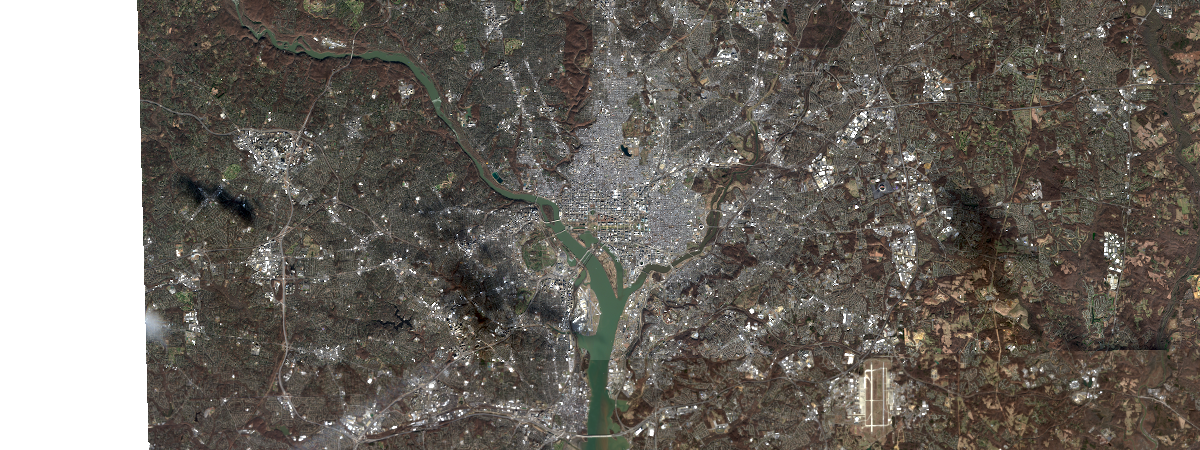

In [81]:
selected.last()

# Change Detection

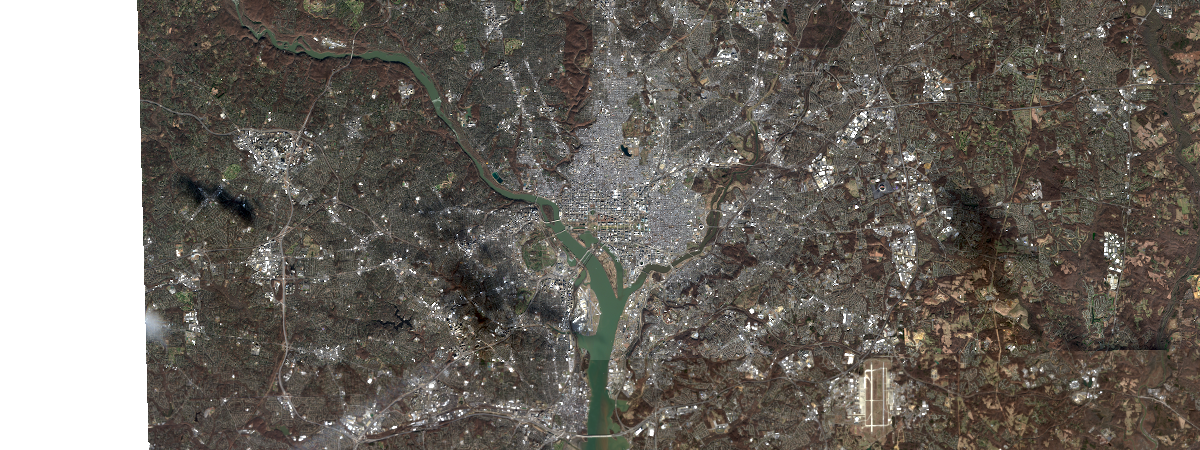

In [93]:
new = selected.last()
new

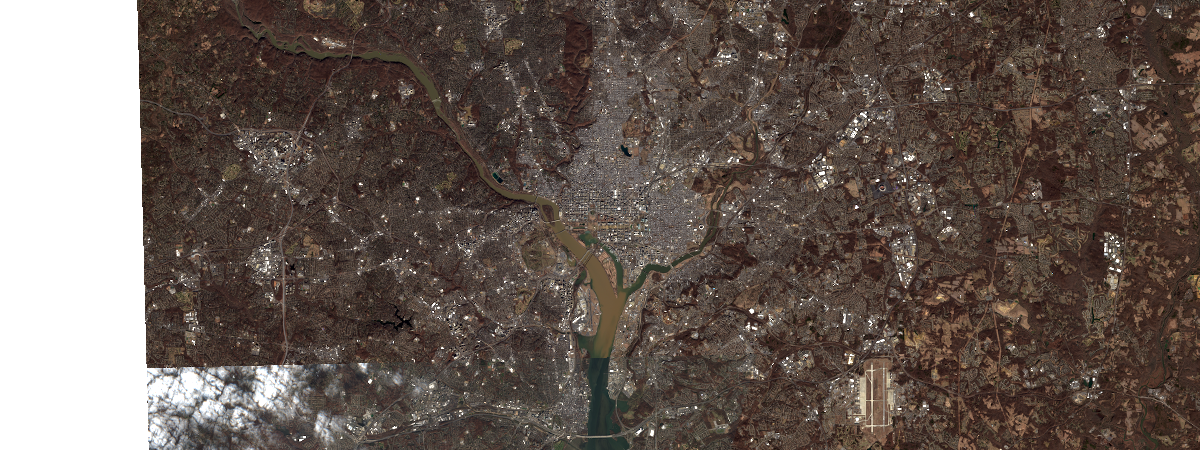

In [94]:
old = selected.first()
old

## Difference Image

Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta. 

In [95]:
from arcgis.raster.functions import *

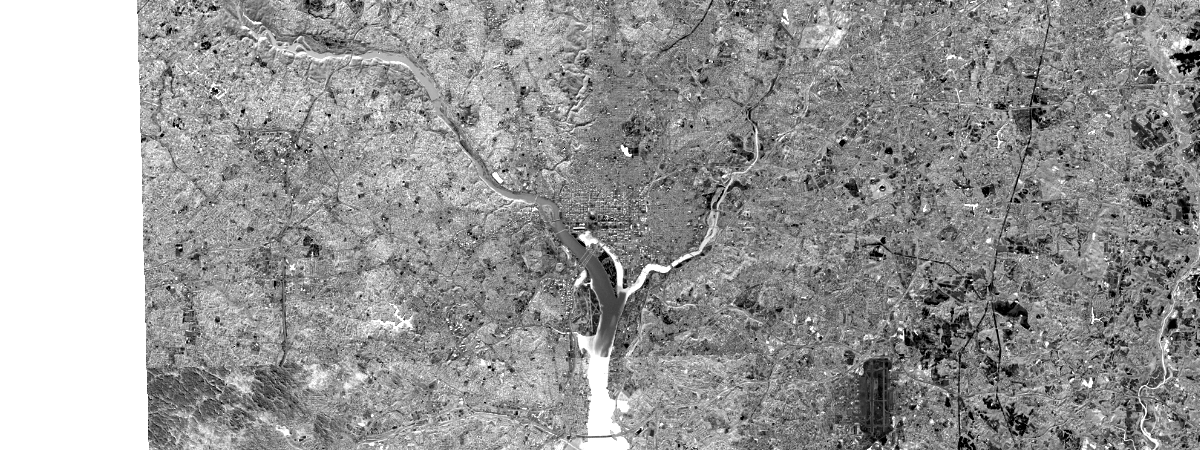

In [105]:
diff = stretch(composite_band([ndvi(old, '3 4'),
                               ndvi(new, '3 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, 
                               max=255, dra=True, astype='u8')
diff

### Persisting your analysis for visualizaion or analysis